# Initialisation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os
import pyabf
import seaborn as sns
import shelve
import sys
from scipy.stats import zscore

from sklearn.cluster import AgglomerativeClustering

from scipy.cluster.hierarchy import dendrogram, linkage


# Import data

In [66]:
df_summary = pd.read_csv('/network/lustre/iss01/wyart/analyses/2pehaviour/MLR_analyses/data_summary_BH.csv')
fishlabel, plane = '210203_F01', '70um_00'
print(fishlabel, plane)
output_path = df_summary.loc[(df_summary.fishlabel == fishlabel) & (df_summary.plane == plane), 'output_path'].item()

shelve_out = shelve.open(output_path + '/shelve_calciumAnalysis.out')

old_cells = shelve_out['cells']
dff = shelve_out['dff_f_lp_inter']
df_bouts = pd.read_pickle(output_path + '/dataset/df_bout')
df_frame = pd.read_pickle(output_path + '/dataset/df_frame')
tail_angle = shelve_out['tail_angle']
noise = shelve_out['noise_f_lp']
stat = shelve_out['stat']
fps_ci = shelve_out['fps']
fps_bh = shelve_out['fps_beh']
direction = df_summary.loc[(df_summary.fishlabel == fishlabel) & (df_summary.plane == plane), 'direction'].item()

shelve_out.close()

side_lim = df_summary.loc[(df_summary.fishlabel == fishlabel) & (df_summary.plane == plane), 'midline'].item()

data_path = df_summary.loc[(df_summary.fishlabel == fishlabel) & (df_summary.plane == plane), 'data_path'].item()
ops = np.load(data_path + '/suite2p/plane0/ops.npy', allow_pickle=True).item()
# ops_path = '/network/lustre/iss01/wyart/analyses/2pehaviour/MLR_analyses/calcium_imaging/from_Martin_raw_data/210121_F05_70um_bh/'
# ops = np.load(ops_path + '/ops.npy', allow_pickle=True).item()
time_indices_2p = np.arange(dff.shape[1]) / fps_ci
time_indices_bh = np.arange(len(tail_angle)) / fps_bh


210203_F01 70um_00


# A) Population clustering based on calcium traces

Keep only medulla and retropont cells
& for 210203_F03_70um_04, remove 3 more cells out of fish

In [67]:
cells = []
sc_bulbar = df_summary.loc[(df_summary.fishlabel == fishlabel) & (df_summary.plane == plane), 'sc_bulbar'].item()
for cell in old_cells:
    if direction == 1:
        
        if stat[cell]['med'][1] > sc_bulbar:    
            if (fishlabel == '210203_F03') & (plane == '70um_04'):
                if stat[cell]['med'][0] < 60:
                    print('Removed cell out of fish:', cell)
                else:
                    cells.append(cell)
            else:
                cells.append(cell)
    
    elif direction == 0:
        if stat[cell]['med'][0] < sc_bulbar:
            cells.append(cell)

print('Kept {} hindbrain cells out of {}'.format(len(cells), len(old_cells)))

Kept 78 hindbrain cells out of 94


import functions for agglomerative clustering

In [68]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

write functions to represent pop aglo clustering

In [69]:
def plot_raster(neuron_traces, vmax, ylabel):
    n_neurons = neuron_traces.shape[0]
    plt.figure(figsize=(15, int(n_neurons / 10) + 1))
    plt.imshow(neuron_traces, aspect="auto", vmin=0, vmax=vmax)
    plt.ylabel(ylabel)
    # ax[0].set_yticks(np.arange(neuron_names.shape[0]))
    # ax[0].set_yticklabels(neuron_names)
    plt.colorbar()
    plt.show()



def runAggloClustering_vizu(nClusters, cmap, cmap_name, corr_dff, vmax, data):

    neuron_traces, dff, time_indices, stim_trace, time_indices_stim, stat, ops, cells, fig_path = data

    clustering = AgglomerativeClustering(n_clusters=nClusters, ).fit(corr_dff)
    
    # Plot dendogram
    
    dend = dendrogram(linkage(corr_dff, method='ward'))

    # Sorting the labels assigned to each cell

    labels = clustering.labels_

    for cluster in range(nClusters):
        print('Number of cells in cluster {}: {}'.format(cluster, list(labels).count(cluster)))
        plot_raster(neuron_traces[labels == cluster], vmax, 'cluster ' + str(cluster))

    # Visualisation of cell activity in each cluster

    fig, ax = plt.subplots(figsize=(15, int(neuron_traces.shape[0] / 10) + 1))
    im = ax.imshow(np.concatenate([neuron_traces[labels == cluster] for cluster in range(nClusters)]), 
                   aspect="auto", 
                   vmin=0, vmax=vmax, cmap='Greys')
    previous_length = 0
    for cluster in range(nClusters):
        ax.plot([0, neuron_traces.shape[1]], 
                [len(neuron_traces[labels == cluster])+previous_length]*2,
                '--', color='grey')
        previous_length += len(neuron_traces[labels == cluster])
    ax.set_ylabel(str(nClusters) + ' clusters')
    fig.savefig(fig_path + '/rasterplot_clusters.svg')
    fig,ax = plt.subplots(figsize=(2,6))
    plt.colorbar(im,ax=ax)
    ax.remove()
    plt.savefig(fig_path + '/colorbar_rasterplot_clusters.svg')
    import matplotlib
    matplotlib.image.imsave(fig_path + '/rasterplot.png', 
                            np.concatenate([neuron_traces[labels == cluster] for cluster in range(nClusters)]))
    print('\n traces in each cluster:')

    colors = [cmap(i / 10) for i in range(nClusters)]
    for label in set(labels):
        plt.figure(figsize=(15, 10))
        plt.plot(time_indices_stim, stim_trace + 200, 'k')
        plt.title('In cluster ' + str(label), y=1.05)
        plt.xlabel('Time [s]')
        plt.ylabel('DFF')
        for i, cell in enumerate(np.array(cells)[labels == label]):
            plt.plot(time_indices,dff[cell,:] - i * 30, label='cell ' + str(cell),
                     color=colors[label])
        plt.grid(b=None)
        
        sum_trace = np.sum(dff[np.array(cells)[labels == label]], axis=0)/len(np.array(cells)[labels == label])
        plt.plot(time_indices, sum_trace - (i+1)*30, label='summed trace',
                 color='silver')
        plt.savefig(fig_path + '/calcium_trace_cluster' + str(label) + '.svg')
    
    

    auto_array = np.zeros((ops['Ly'], ops['Lx']))
    auto_array[:] = np.nan
    for i, cell in enumerate(cells):
        ypix = stat[cell]['ypix']
        xpix = stat[cell]['xpix']
        try:
            auto_array[ypix, xpix] = labels[i]
            # auto_array[ops['Ly']-xpix, ops['Lx']-ypix] = labels[i]
                
        except IndexError:
            pass
        
    plt.figure(figsize=(15, 15))
    plt.imshow(ops['meanImg'], cmap='Greys')
    plt.imshow(auto_array, alpha=0.7, vmin=0, vmax=10, cmap=cmap_name)
    # plt.imshow(np.swapaxes(auto_array, 0,1), alpha=0.7, vmin=0, vmax=10, cmap=cmap_name)
    plt.title('Automatic clustering')
    plt.grid(b=None)
    plt.colorbar()
    plt.savefig(fig_path + '/clusters_pos.svg')
    
    colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'grey', 'olivedrab', 'cyan']
    plt.figure(figsize=(15, 15))
    plt.imshow(ops['meanImg'], cmap='Greys')
    for i, cell in enumerate(cells):
        try:
            plt.scatter(stat[cell]['med'][1], stat[cell]['med'][0], marker='o', s=60, color=colors[labels[i]])

        except IndexError:
            pass
        
    # plt.imshow(auto_array, alpha=0.7, vmin=0, vmax=10, cmap=cmap_name)
    # plt.imshow(np.swapaxes(auto_array, 0,1), alpha=0.7, vmin=0, vmax=10, cmap=cmap_name)
    plt.title('Automatic clustering')
    plt.grid(b=None)
    plt.colorbar()
    plt.savefig(fig_path + '/clusters_pos_dot.svg')

    return labels

build neuron traces

In [70]:
%matplotlib inline

In [71]:
# max_frame = int(fps_ci*30)
max_frame = dff.shape[1]
# cells_to_keep = [i for i in cells if np.array(dff)[i,:max_frame].sum() != 0]
cells_to_keep = cells.copy()
neuron_traces = pd.DataFrame(np.array(dff)[cells_to_keep,:max_frame])


# neuron_traces_zscore = np.array(neuron_traces).copy()
# for neuron in range(neuron_traces.shape[0]):
#     neuron_traces_zscore[neuron,:] = zscore(np.array(neuron_traces)[neuron,:])

calculate correlation matrix

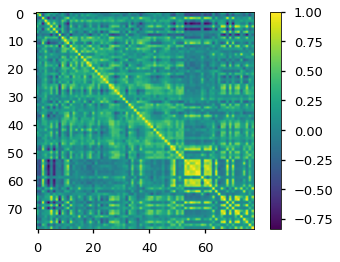

In [72]:
corr_dff = neuron_traces.T.corr()

plt.imshow(corr_dff)
plt.colorbar()

calculate cross correlation matrix

Text(0.5, 1.0, 'Lags')

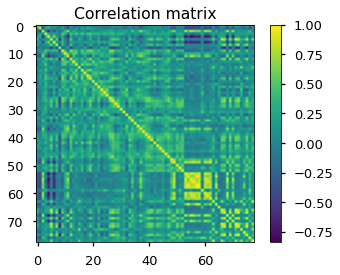

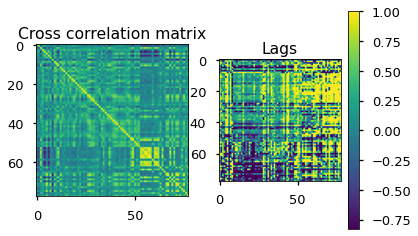

In [73]:
# fct
def find_max_cross_corr(i, j, df, n_lags):
    all_lags = list(range(-n_lags, n_lags))
    corr_values = [df.iloc[i].corr(df.iloc[j].shift(n)) for n in all_lags]
    max_index, max_corr = np.argmax(corr_values), np.max(corr_values)
    return all_lags[max_index], max_corr



cross_corr_matrix = np.zeros((neuron_traces.shape[0], neuron_traces.shape[0]))
lags_matrix = np.zeros((neuron_traces.shape[0], neuron_traces.shape[0]))

for i in range(neuron_traces.shape[0]):
    for j in range(neuron_traces.shape[0]):
        lags_matrix[i,j], cross_corr_matrix[i,j] = find_max_cross_corr(i, j, neuron_traces, 3)

plt.figure()
plt.imshow(corr_dff)
plt.title('Correlation matrix')
plt.colorbar()
fig, ax = plt.subplots(1,2)
ax[0].set_title('Cross correlation matrix')
s = ax[0].imshow(cross_corr_matrix)
fig.colorbar(s)
ax[1].imshow(lags_matrix)
ax[1].set_title('Lags')

apply agglomerative clustering

In [74]:
cmap_name = 'tab10'
cmap = matplotlib.cm.get_cmap(cmap_name)

Number of cells in cluster 0: 25


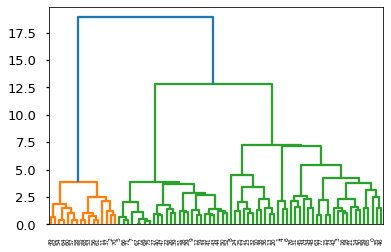

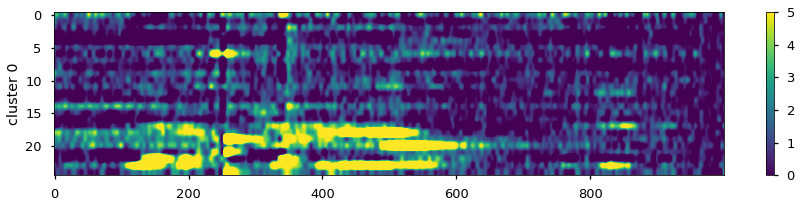

Number of cells in cluster 1: 11


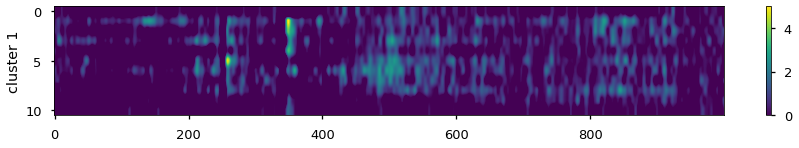

Number of cells in cluster 2: 26


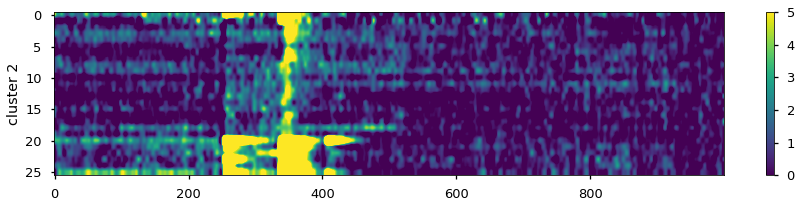

Number of cells in cluster 3: 16


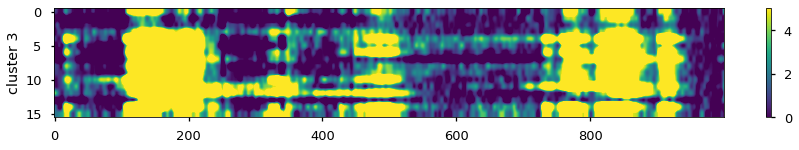


 traces in each cluster:


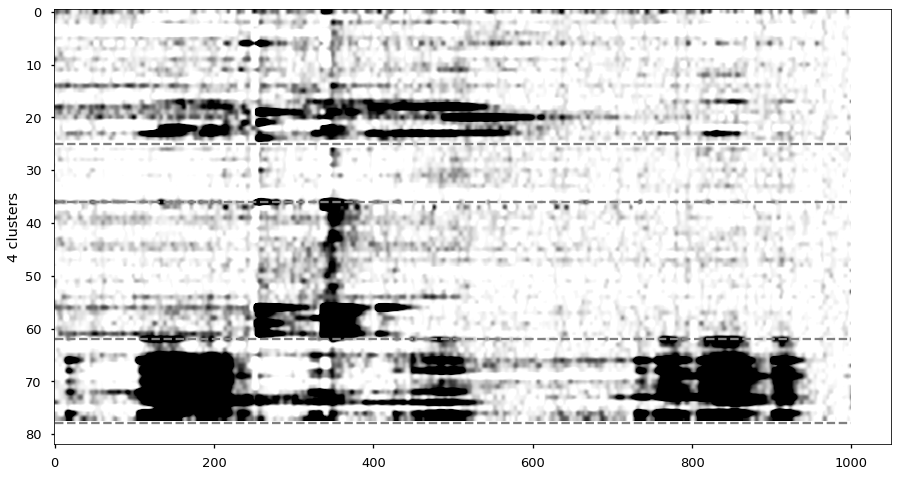

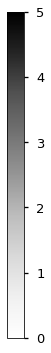

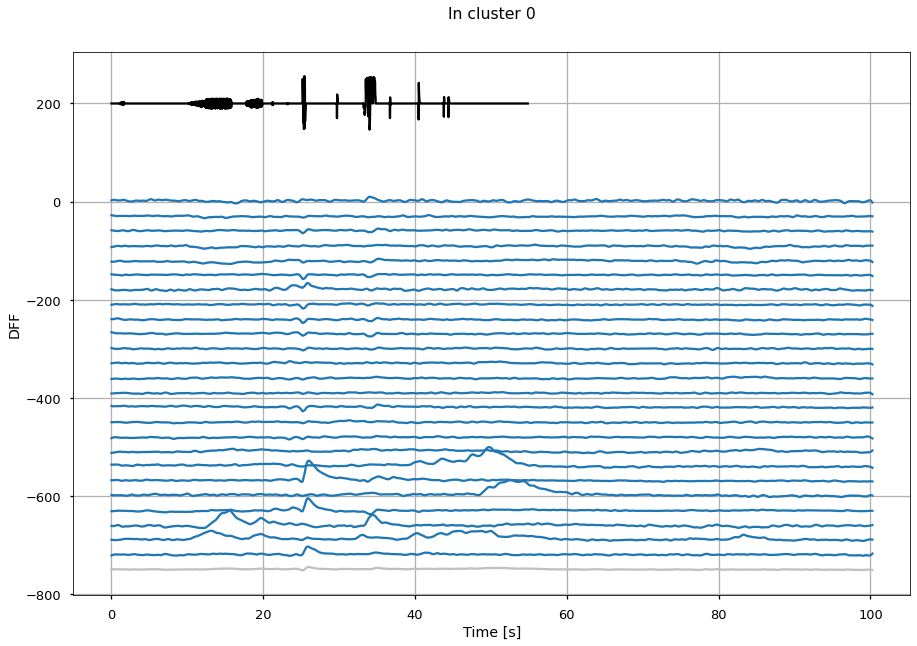

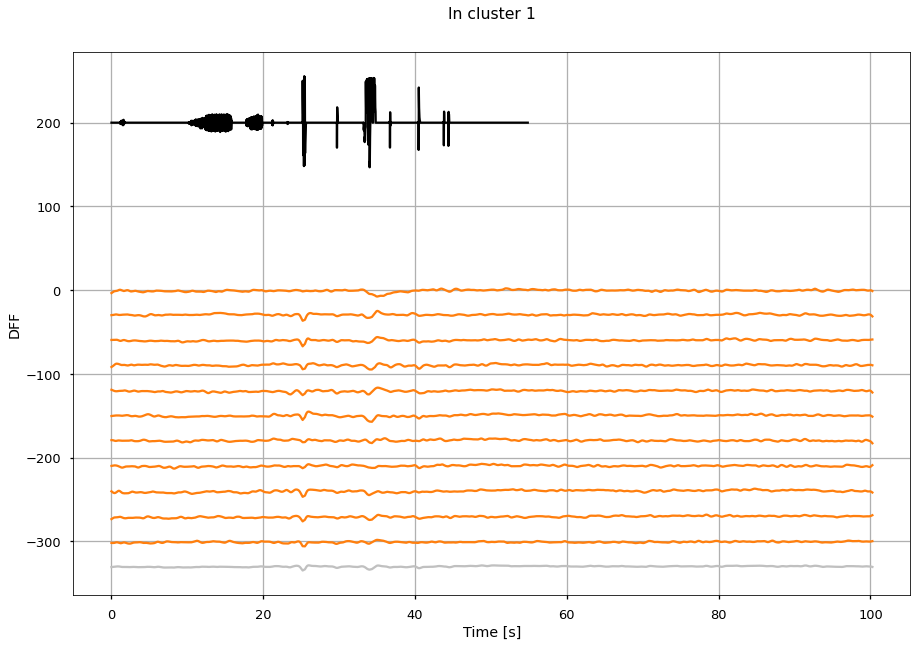

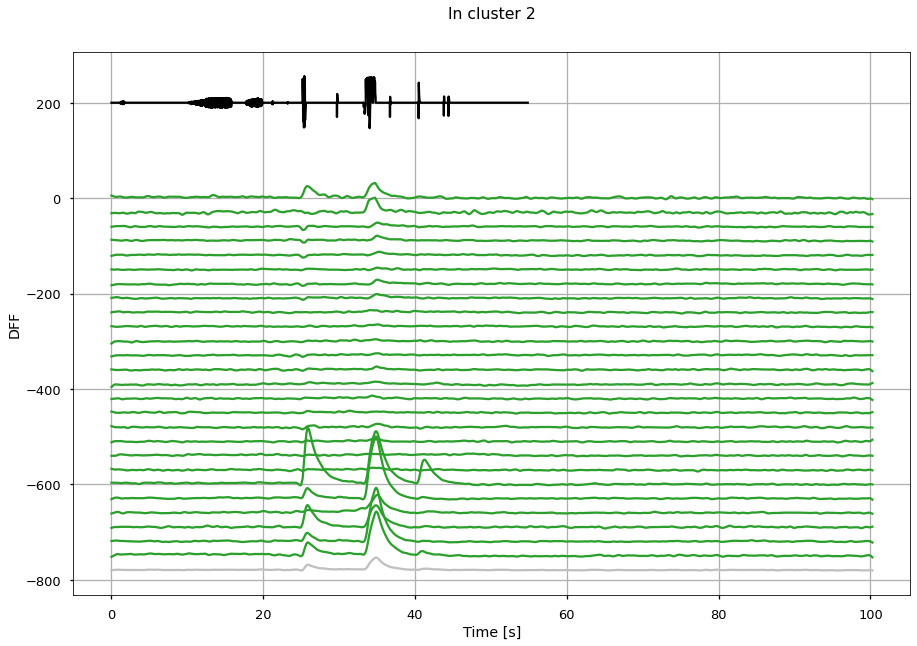

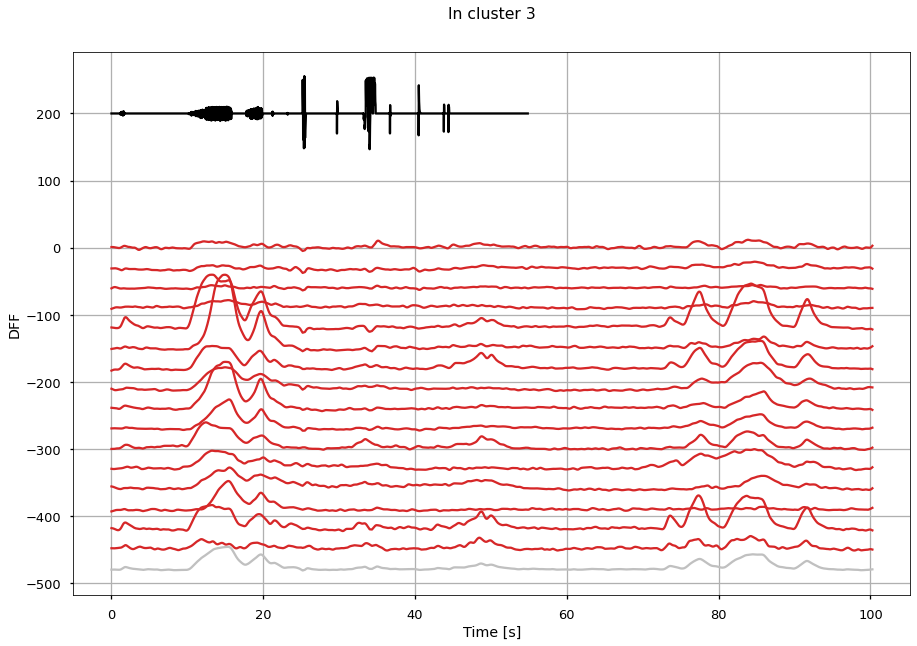

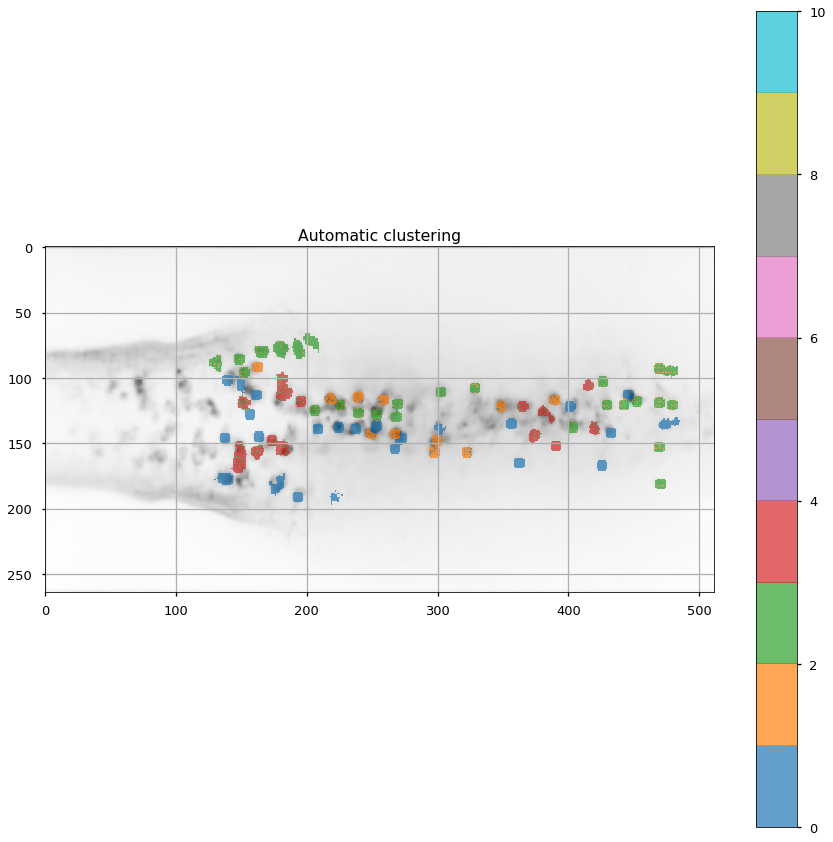

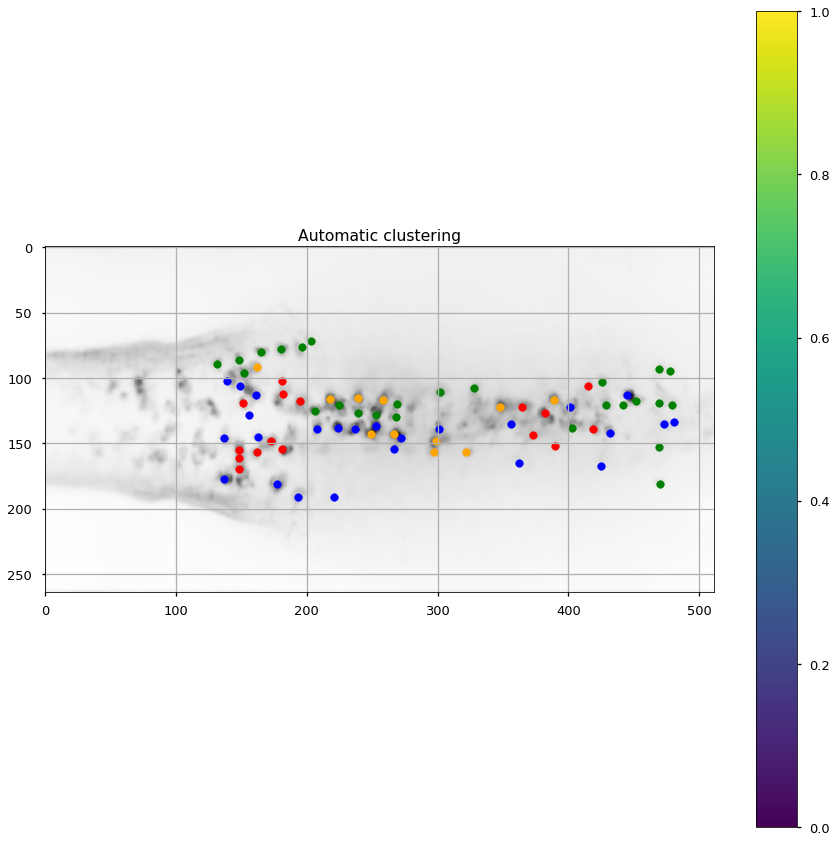

In [75]:
initial_fig_path = '/network/lustre/iss01/wyart/analyses/2pehaviour/MLR_analyses/ML_pipeline_output/fig6/'

fig_path = initial_fig_path + fishlabel + '_' + plane + '/'
try:
    os.mkdir(fig_path)
except FileExistsError:
    pass

vmax=5
nClusters = 4
data = (neuron_traces, dff, time_indices_2p, tail_angle, time_indices_bh, 
        stat, ops, np.array(cells_to_keep), fig_path)
colors = [cmap(i/10) for i in range(nClusters)]

pop_clustering_labels = runAggloClustering_vizu(nClusters, cmap, cmap_name, cross_corr_matrix, vmax, data)

np.save(output_path + '/dataset/labels_pop_clusters.npy', pop_clustering_labels)
# np.save(output_path + '/dataset/neuron_traces_zscore.npy', neuron_traces_zscore)

# B) Build regressor recapitulating behavior features

In [13]:
plt.style.use('seaborn-poster')

### resample tail angle

Text(0.5, 0, 'Time [s]')

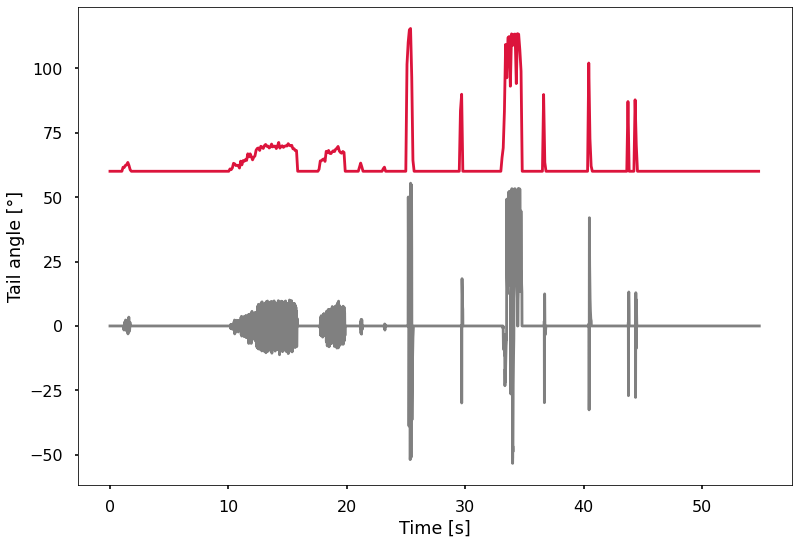

In [14]:
def resample(tail_angle, fps_bh, fps_ci):
    fq1 = str(round(1/fps_bh, 6))+'S'
    fq2 = str(round(1/fps_ci, 6))+'S'
    df_ta = pd.Series(np.abs(tail_angle), index=pd.date_range(start="00:00:00",
                                                      periods=len(tail_angle),
                                                      freq=fq1))
    ta_resampled = np.array(df_ta.resample(fq2).max())
    
    return ta_resampled
    

tail_angle_resampled = resample(tail_angle, fps_bh, fps_ci)

plt.plot(time_indices_bh, tail_angle, color='grey')
plt.plot(time_indices_2p[0:len(tail_angle_resampled)], tail_angle_resampled+60, color='crimson')
plt.ylabel('Tail angle [°]')
plt.xlabel('Time [s]')

### build frequency array

Text(0.5, 0, 'Time [s]')

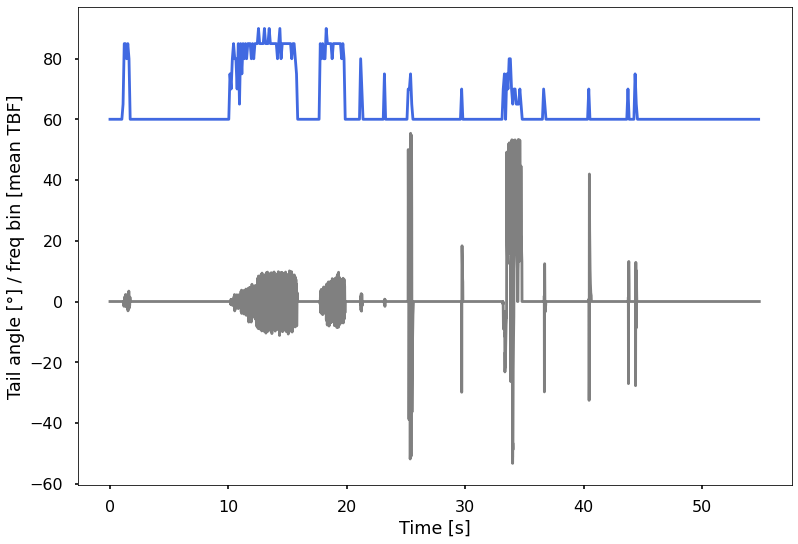

In [15]:
def bin_mean_freq(frame):
    try:
        time = time_indices_2p[frame]
        next_time = time_indices_2p[frame+1]
        bh_inf, bh_sup = int(time*fps_bh), int(next_time*fps_bh)
        n_osc = len(df_frame[(df_frame.index.isin(range(bh_inf, bh_sup))) & (df_frame.Bend_Amplitude.notna())])/2
        if n_osc != 0:
            output = n_osc * fps_ci
        else:
            output = 0
    except IndexError:
        output = 0
    return output
        
        
freq_array = pd.Series(np.arange(len(tail_angle_resampled))).apply(bin_mean_freq)

plt.plot(time_indices_bh, tail_angle, color='grey')
plt.plot(time_indices_2p[0:len(freq_array)], freq_array+60, color='royalblue')
plt.ylabel('Tail angle [°] / freq bin [mean TBF]')
plt.xlabel('Time [s]')

### build regressors

In [16]:
def nandot(X, Y):
    """Sum two arrays, but taking the NaN into account (sum functions does not naturally)"""
    return np.nansum(X * Y)


def calcium_kernel(tau):
    """Builds calcium transient trace, based on a tau value defined by user.

    :param tau: The tau value you want to give to your exponential decay

    :return: exponential function with tau decay
    """
    return lambda x: np.exp(- x / (tau / np.log(2)))


def convolve_regressors(regressor, kernel):
    """ Convolves the regressor with a kernel function
    :param regressor: the regressor, or regressor matrix
    :param kernel:
    :return: the convolved kernel
    """
    return np.convolve(regressor, kernel)[0:len(regressor)]


def create_regressor(ta_resampled,  tau: float, fps_ci: float):
    """
    Create motor regressor; e.g signal mimicking fluorescence of a cell expressing calcium indicator
    if it was linearlt encoding the behavior of interest.

    :param ta_resampled: array of tail angle resampled at matching frequency of acquisition with the calcium signal
    :param tau: tau decay of calcium kernel
    :param fps_ci: float, frequency of acquisition of the calcium imaging signal
    :return:
    """


    ker = calcium_kernel(tau)(np.arange(0, 10, 1 / fps_ci))
    ker_zeros = np.zeros((int(2 * fps_ci)))
    ker2 = np.concatenate((ker_zeros, ker, ker_zeros))

    regressor = zscore(convolve_regressors(np.array(ta_resampled).flatten(), ker))


    return regressor

In [17]:
# build df signal

In [18]:
dict_signal = {}
for i, j in enumerate(cells):
    dict_signal[i] = pd.DataFrame({'cell': j,
                                  'time_point': np.arange(dff.shape[1])/fps_ci,
                                  'frame': np.arange(dff.shape[1]),
                                  'dff': dff[j,:],
                                   'zscore_dff': zscore(dff[j,:]),
                                  'cluster': pop_clustering_labels[i]})

df_signal = pd.concat(dict_signal, ignore_index=True)
df_signal.head()

,cell,time_point,frame,dff,zscore_dff,cluster
0,4,0.000000,0,2.576632,0.462075,0
1,4,0.100351,1,3.123080,0.790442,0
2,4,0.200702,2,3.554878,1.049915,0
3,4,0.301054,3,3.744087,1.163613,0
4,4,0.401405,4,3.630116,1.095126,0


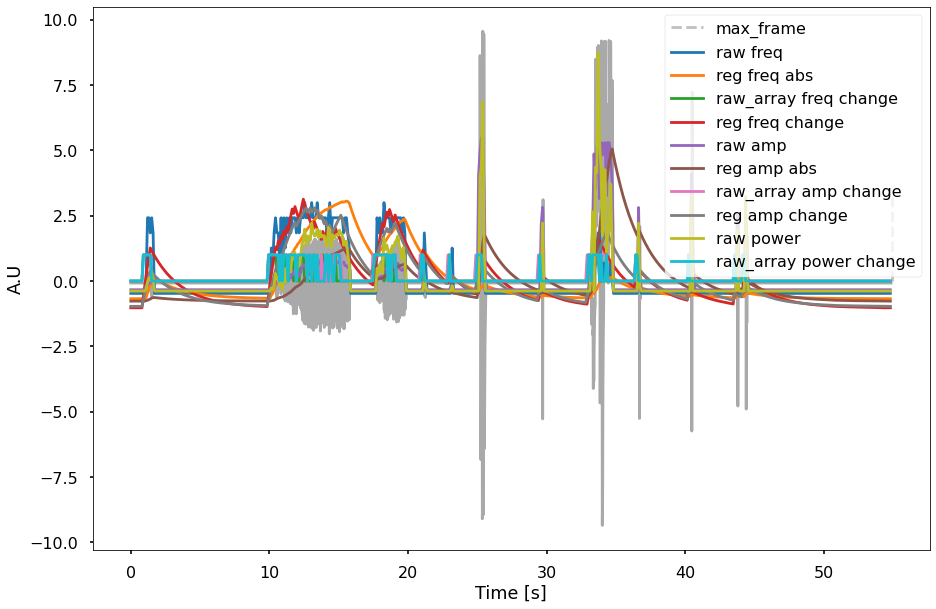

In [19]:
import utilsRegressors as utilsReg

# Compute all regressors

raw_arrays = dict()
regressors = dict()
tau = 1.5
w = 5
max_frame = len(tail_angle_resampled)

fig, ax = plt.subplots(figsize=(15,10))

ax.plot([time_indices_2p[max_frame]]*2, [0,3.5], '--', color='silver', label='max_frame')
ax.plot(time_indices_bh, zscore(tail_angle), color='darkgrey')

for i, variable in enumerate(['freq', 'amp', 'power']):
    
    if variable == 'freq':
        raw_array = freq_array
    elif variable == 'amp':
        raw_array = tail_angle_resampled
    elif variable == 'power':
        raw_array = utilsReg.compute_power(freq_array, tail_angle_resampled)
        
    ax.plot(time_indices_2p[:len(raw_array)], zscore(raw_array), label='raw {}'.format(variable))
        
    for j, reg_type in enumerate(['abs', 'change']):
        
        if reg_type == 'abs':
            regressor = create_regressor(raw_array, tau, fps_ci)
            raw_arrays[variable+'_'+reg_type] = raw_array
        elif reg_type == 'change':
            change_array = utilsReg.compute_absolute_change(raw_array, w)
            regressor = create_regressor(change_array, tau, fps_ci)
            ax.plot(time_indices_2p[:len(change_array)], change_array, label='raw_array {} {}'.format(variable, reg_type))
            raw_arrays[variable+'_'+reg_type] = change_array
            
        regressors[variable+'_'+reg_type] = regressor
        
        if variable != 'power':
            ax.plot(time_indices_2p[:len(regressor)], regressor, label='reg {} {}'.format(variable, reg_type))
        
# sns.lineplot(data=df_signal[(df_signal.cluster == cluster_chosen) & (df_signal.frame <= max_frame)], x='time_point', y='zscore_dff', ax=ax)
            
ax.legend()
ax.set_xlabel('Time [s]')
ax.set_ylabel('A.U')
# plt.savefig(fig_path + '/all_regressors_behavior.svg')

np.save(fig_path + '/regressors.npy', regressors)
np.save(fig_path + '/raw_arrays.npy', raw_arrays)


# C) Build Linear Regression Model to explain clusters activity with behavior features

For each cluster, compute mean trace and find if behavior features explain the mean trace.

In [20]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

compute mean trace for each cluster

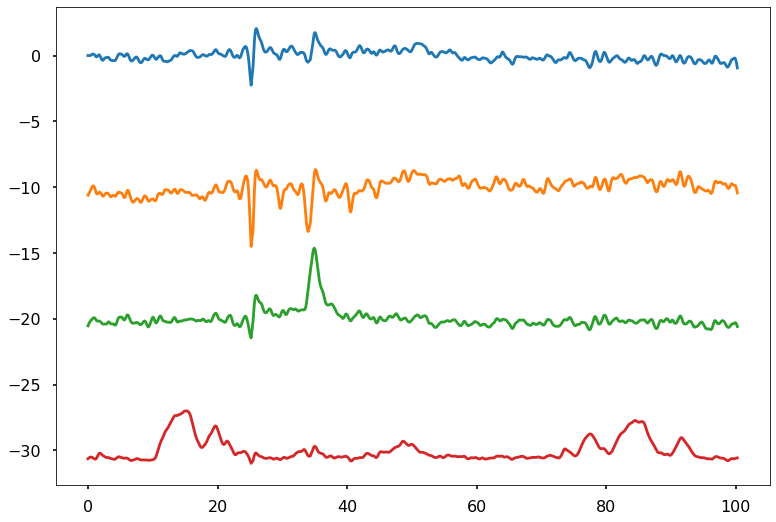

In [21]:
mean_trace_clusters = np.zeros((len(set(pop_clustering_labels)), dff.shape[1]))
cells = np.array(cells)

for i in set(pop_clustering_labels):
    cluster = int(i)
    dff_cluster = zscore(dff[cells[pop_clustering_labels == cluster],:], axis=1)
    mean_trace_clusters[cluster,:] = np.mean(dff_cluster, axis=0)
    plt.plot(time_indices_2p, mean_trace_clusters[cluster,:]-cluster*10)

In [22]:
# compute dataframe with signal and cluster id

build matrix with features of interest

In [23]:
features = ['freq_abs', 'freq_change', 'amp_abs', 'amp_change']
# max_frame = next(frame for frame in np.arange(len(tail_angle_resampled)) if tail_angle_resampled[frame] > 50)-10
# print(max_frame)
max_frame = 230 # cut trace to build model on forward events only
# from math import floor
# max_frame = floor(20*fps_ci)
print(max_frame)
features_matrix = np.stack([zscore(regressors[i][:max_frame]) for i in features]).T
np.save(fig_path + '/features_matrix.npy', features_matrix)

230


Which cluster is best explained by the features ?

In [24]:
for cluster in set(pop_clustering_labels):
    print('\n\nCluster ',cluster)
    X = features_matrix
    Y = mean_trace_clusters[cluster,:len(X)]
    results = sm.OLS(Y, X).fit()
    print(results.params)
    print(results.summary())



Cluster  0
[-0.2783  0.2421  0.52   -0.3389]
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.456
Model:                            OLS   Adj. R-squared (uncentered):              0.447
Method:                 Least Squares   F-statistic:                              47.42
Date:                Mon, 13 Dec 2021   Prob (F-statistic):                    6.56e-29
Time:                        11:45:17   Log-Likelihood:                          79.424
No. Observations:                 230   AIC:                                     -150.8
Df Residuals:                     226   BIC:                                     -137.1
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0

pick the best one and explore which features explains it best

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.857
Model:                            OLS   Adj. R-squared (uncentered):              0.854
Method:                 Least Squares   F-statistic:                              338.6
Date:                Mon, 13 Dec 2021   Prob (F-statistic):                    3.54e-94
Time:                        11:45:18   Log-Likelihood:                         -162.54
No. Observations:                 230   AIC:                                      333.1
Df Residuals:                     226   BIC:                                      346.8
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

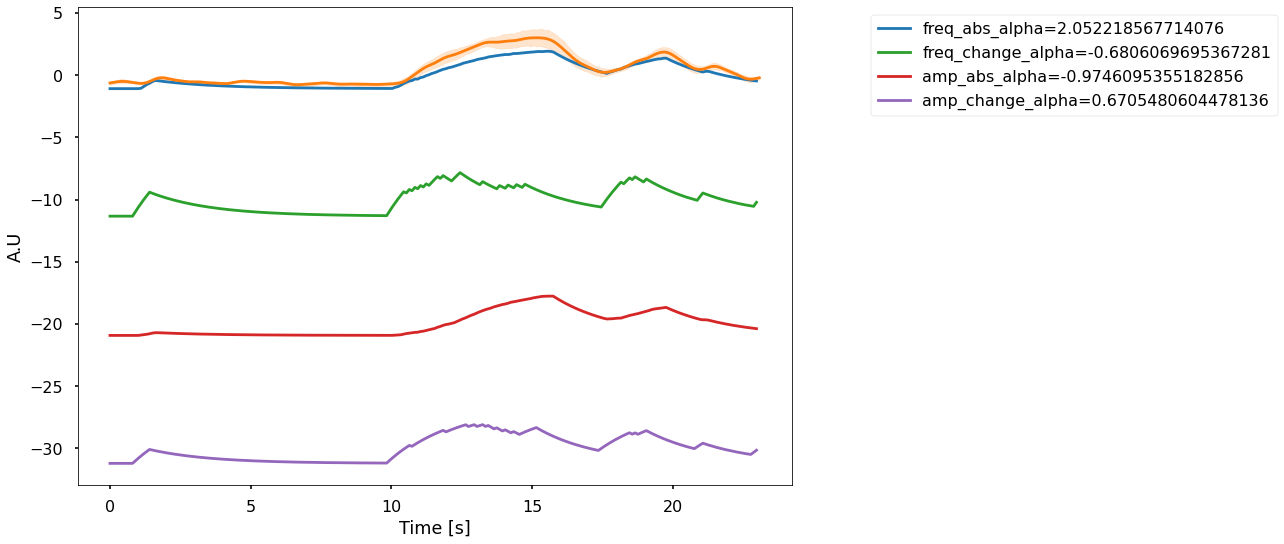

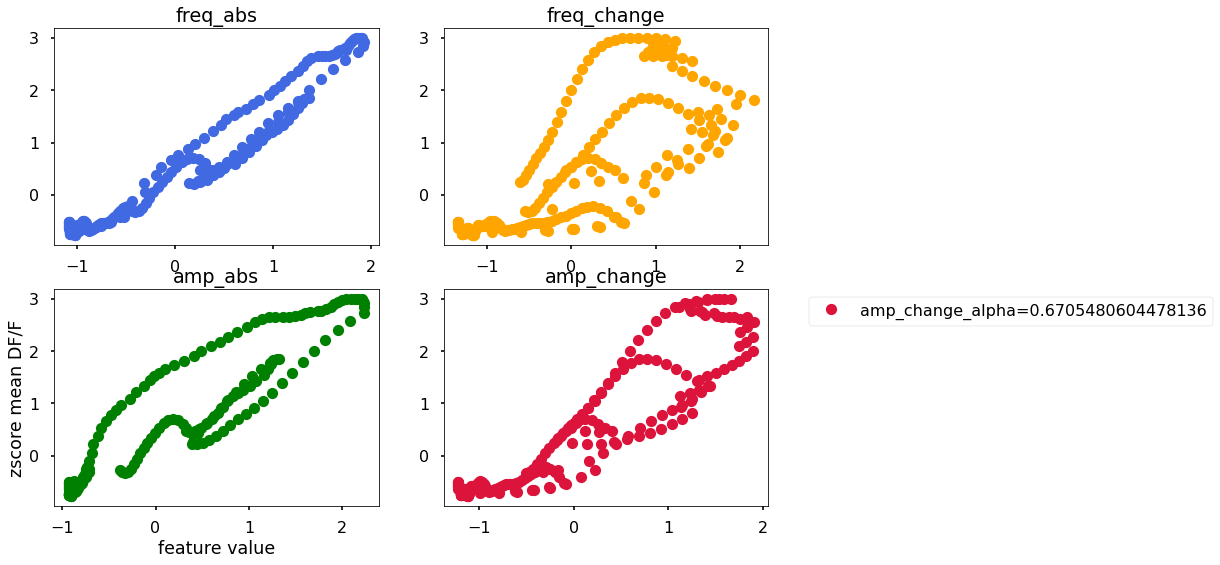

In [25]:
# cluster_chosen = int(input('Chosen cluster ?'))
cluster_chosen = 3

X = features_matrix
Y = mean_trace_clusters[cluster_chosen,:len(X)]
colors = ['royalblue', 'orange', 'green', 'crimson', 'purple']
results = sm.OLS(Y, X).fit()
print(results.summary())
fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots(2,2)
ax2_f = ax2.flatten()
for i, feature in enumerate(features):
    ax1.plot(time_indices_2p[:len(X)], X[:,i]-i*10, label='{}_alpha={}'.format(feature, results.params[i]))
    # ax1.plot(Y-i*10, color='silver')
    if i == 0:
        sns.lineplot(data=df_signal[(df_signal.cluster == cluster_chosen) & (df_signal.frame <= max_frame)], x='time_point', y='zscore_dff', ax=ax1)
    ax2_f[i].set_title(feature)
    ax2_f[i].plot(X[:,i], Y, 'o', label='{}_alpha={}'.format(feature, results.params[i]), 
                  color=colors[i])
ax1.legend(bbox_to_anchor=(1.1,1))
ax1.set_xlabel('Time [s]')
ax1.set_ylabel('A.U')
ax2_f[-1].legend(bbox_to_anchor=(1.1,1))
ax2_f[2].set_ylabel('zscore mean DF/F')
ax2_f[2].set_xlabel('feature value')
fig1.savefig(fig_path + '/mean_trace_plotted_with_each_reg.svg')
fig2.savefig(fig_path + '/mean_trace_against_each_features.svg')

# D) Find whether neurons within cluster are explained by different features

In [26]:
# store for each neuron, results of fitting
df_linReg = pd.DataFrame({'neuron': np.tile(cells[pop_clustering_labels == cluster_chosen], len(features)), 
                          'feature_label': np.repeat(features, len(cells[pop_clustering_labels == cluster_chosen])), 
                          'feature_id': np.repeat(range(len(features)), len(cells[pop_clustering_labels == cluster_chosen])),
                          'alpha': np.nan, 
                          'pvalue': np.nan})

# fit the model for each neuron trace
for i in df_linReg.index:
    neuron = df_linReg.neuron[i]
    X = features_matrix
    Y = dff[neuron,:len(X)]
    results = sm.OLS(Y, X).fit()
    feature_label = df_linReg.feature_label[i]
    feature_id = df_linReg.feature_id[i]
    df_linReg.at[i, 'alpha'] = results.params[feature_id]
    df_linReg.at[i, 'pvalue'] = results.pvalues[feature_id]
    
# correct alpha with pvalue
df_linReg['significant_pvalue'] = df_linReg.pvalue <= 0.05
df_linReg['invert_pvalue'] = 1/df_linReg.pvalue
df_linReg['alpha_norm'] = np.nan
df_linReg.loc[df_linReg.significant_pvalue, 'alpha_norm'] = df_linReg[df_linReg.significant_pvalue].alpha


,neuron,feature_label,feature_id,alpha,pvalue,significant_pvalue,invert_pvalue,alpha_norm
0,6,freq_abs,0,8.653702,0.000776,True,1288.602263,8.653702
1,15,freq_abs,0,5.232589,0.000010,True,105039.554013,5.232589
2,41,freq_abs,0,2.957828,0.000218,True,4593.761773,2.957828
3,53,freq_abs,0,6.054970,0.146675,False,6.817808,NaN
4,60,freq_abs,0,74.277769,0.001764,True,566.876403,74.277769


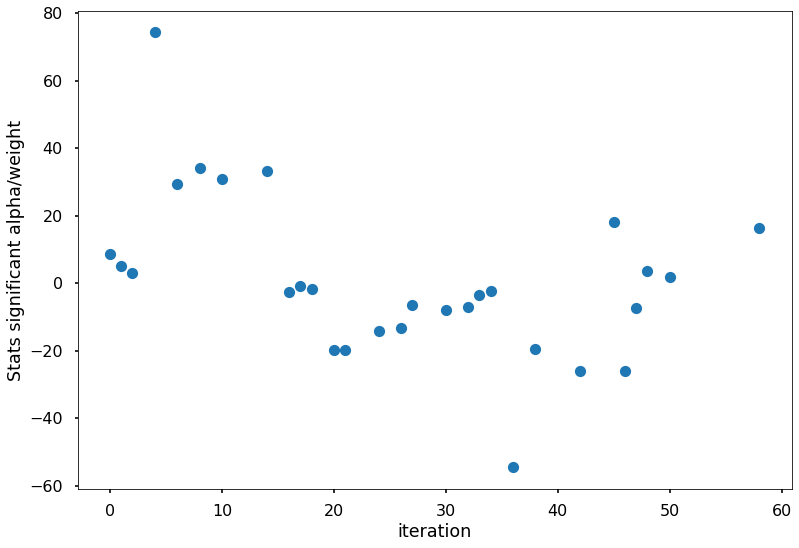

In [27]:
# Visu

# visualise stats significant alpha
plt.plot(df_linReg.alpha_norm, 'o')
plt.xlabel('iteration')
plt.ylabel('Stats significant alpha/weight')

# df
df_linReg.head()

## I. Kmean clustering of neurons based on their weights in the Linreg model

convert dataframe in wide format that will be used for kmean cluster

In [28]:
from sklearn.cluster import KMeans

In [29]:
neurons_weights_wide = pd.DataFrame({'alpha0': list(df_linReg[df_linReg.feature_id == 0].alpha),
                                     'alpha1': list(df_linReg[df_linReg.feature_id == 1].alpha),
                                     'alpha2': list(df_linReg[df_linReg.feature_id == 2].alpha),
                                     'alpha3': list(df_linReg[df_linReg.feature_id == 3].alpha)})

### find proper number of clusters to be used

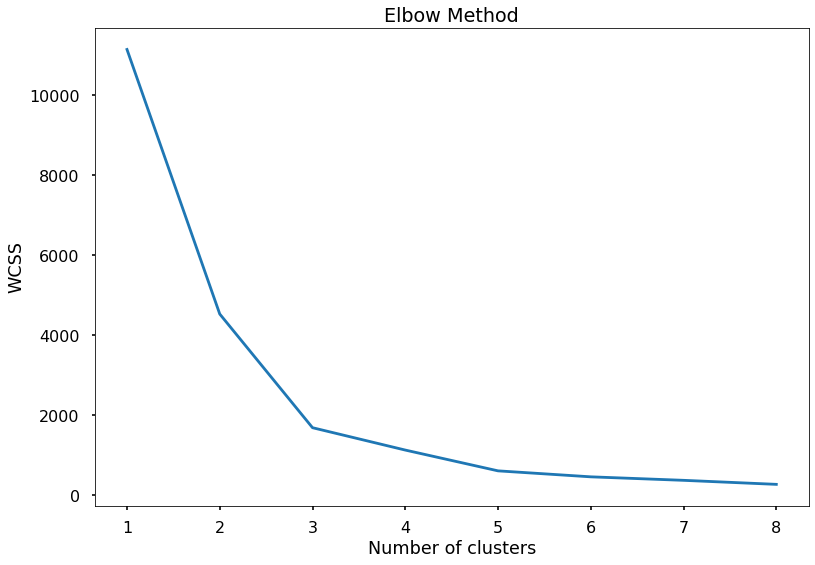

In [30]:
wcss = [] # store inertia of model

for i in range(1,9):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(neurons_weights_wide)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 9), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

### apply

In [31]:
n_clusters_kmean = int(input('Number of clusters for kmean ?'))

kmeans = KMeans(n_clusters=n_clusters_kmean, init='k-means++', max_iter=300, n_init=10, random_state=0)

results_kmean = kmeans.fit_predict(neurons_weights_wide[['alpha0', 'alpha1', 'alpha2', 'alpha3']])
neurons_weights_wide['label'] = results_kmean
df_linReg['kmean_label'] = np.tile(results_kmean, len(features))

Number of clusters for kmean ? 5


## II. Represent clusters

### distribution of weights in each cluster

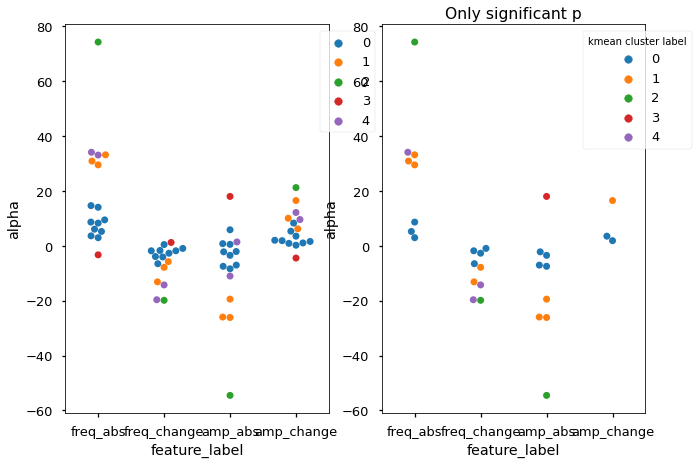

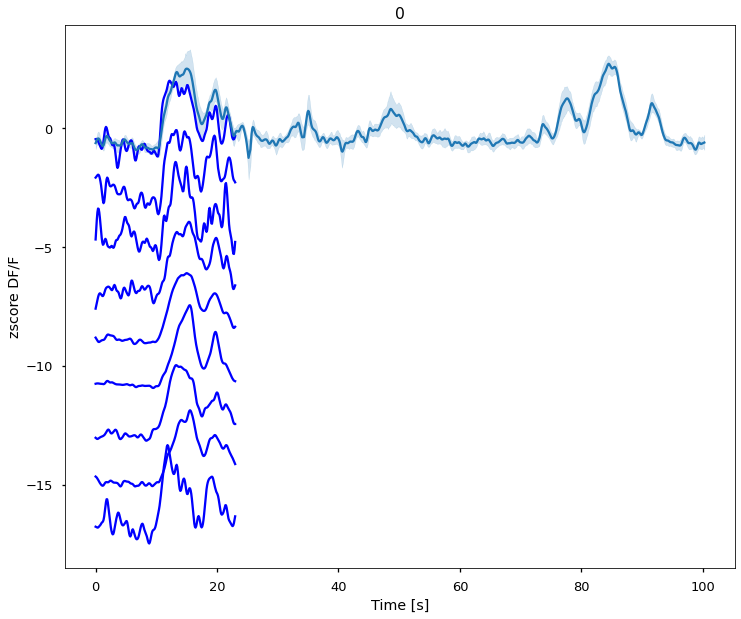

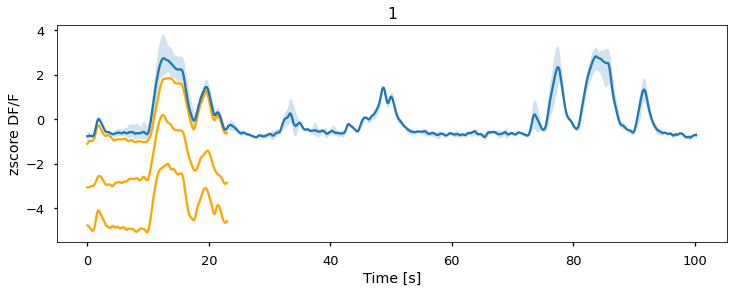

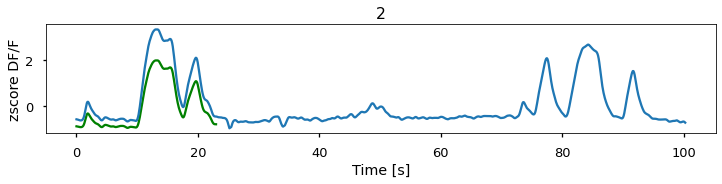

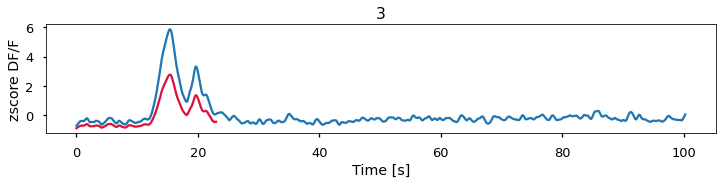

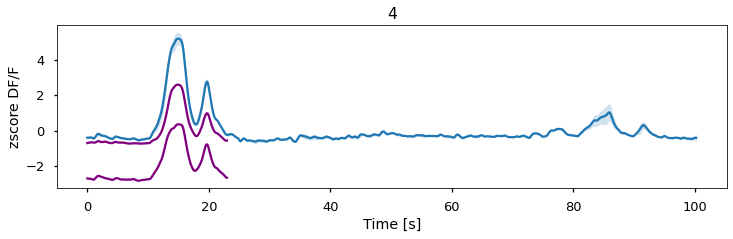

In [32]:
### distribution of weights

plt.style.use('seaborn-talk')

fig, ax = plt.subplots(1,2)
sns.swarmplot(data=df_linReg, y='alpha', x='feature_label', size=7, 
              hue='kmean_label',ax=ax[0], palette='tab10')
ax[0].legend(bbox_to_anchor=(1.2,1))

ax[1].set_title('Only significant p')
sns.swarmplot(data=df_linReg[df_linReg.significant_pvalue], y='alpha', x='feature_label',  size=7, 
              hue='kmean_label',ax=ax[1], palette='tab10')
ax[1].legend(bbox_to_anchor=(1.2,1), fancybox=True, title='kmean cluster label')
fig.savefig(fig_path + '/alpha_per_cluster.svg')

### traces

colors = ['blue', 'orange', 'green', 'crimson', 'purple']
for label in range(n_clusters_kmean):
    neurons_cluster = cells[pop_clustering_labels == cluster_chosen][results_kmean == label]
    plt.figure(figsize=(12,(len(neurons_cluster)+1)))
    plt.title(label)
    for i, j in enumerate(neurons_cluster):
        plt.plot(time_indices_2p[:max_frame], 
                 zscore(dff[j,:max_frame])-i*2, color=colors[label])
    sns.lineplot(data=df_signal[df_signal.cell.isin(neurons_cluster)], x='time_point', y='zscore_dff')
    plt.xlabel('Time [s]')
    plt.ylabel('zscore DF/F')
    plt.savefig(fig_path + '/traces_kmean_cluster{}.svg'.format(label))


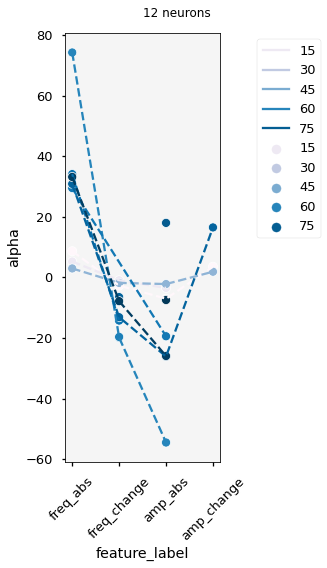

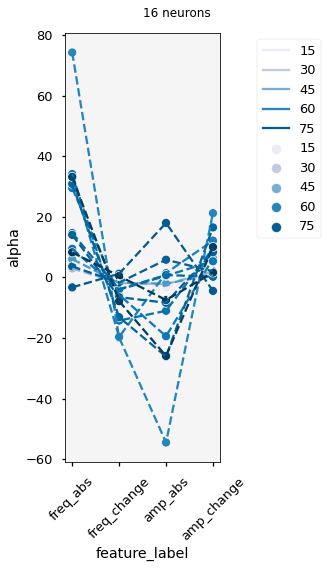

In [33]:
plt.style.use('seaborn-talk')

fig, ax = plt.subplots(figsize=(5,8))
fig.suptitle('{} neurons'.format(len(df_linReg[df_linReg.significant_pvalue].neuron.unique())))
ax.set_facecolor('whitesmoke')
sns.lineplot(data=df_linReg[df_linReg.significant_pvalue], y='alpha', x='feature_label', 
              hue='neuron',ax=ax, palette='PuBu', 
             linestyle='--', markers=True, dashes=False)
sns.scatterplot(data=df_linReg[df_linReg.significant_pvalue], y='alpha', x='feature_label', 
              hue='neuron',ax=ax, palette='PuBu', 
             )
ax.legend(bbox_to_anchor=(1.2,1))
ax.tick_params(axis='x', which='both', rotation=45)
plt.tight_layout()
plt.savefig(fig_path+'/sig_alpha_colorcode_by_neuron.svg')
plt.style.use('seaborn-talk')

fig, ax = plt.subplots(figsize=(5,8))
fig.suptitle('{} neurons'.format(len(df_linReg.neuron.unique())))
ax.set_facecolor('whitesmoke')
sns.lineplot(data=df_linReg, y='alpha', x='feature_label', 
              hue='neuron',ax=ax, palette='PuBu', 
             linestyle='--', markers=True, dashes=False)
sns.scatterplot(data=df_linReg, y='alpha', x='feature_label', 
              hue='neuron',ax=ax, palette='PuBu', 
             )
ax.legend(bbox_to_anchor=(1.2,1))
ax.tick_params(axis='x', which='both', rotation=45)
plt.tight_layout()
plt.savefig(fig_path+'/all_alpha_colorcode_by_neuron.svg')

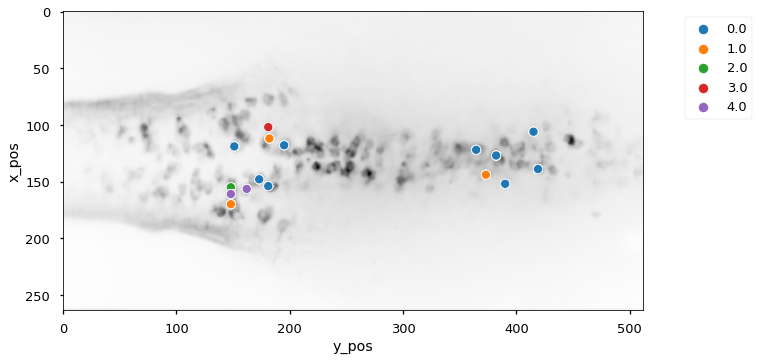

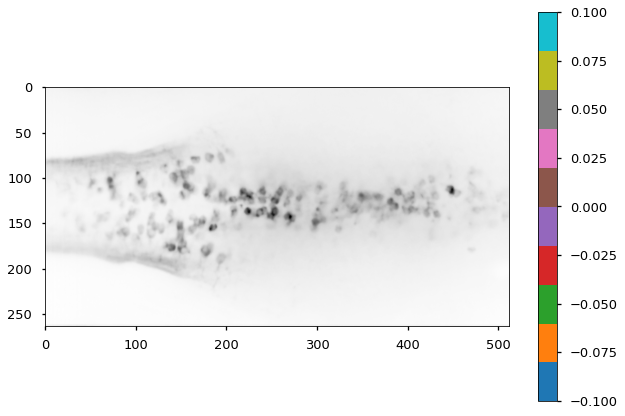

In [34]:
### map

save_path = '/network/lustre/iss01/wyart/analyses/mathilde.lapoix/MLR/V2a_recruitment_behavior/analysis_11/'
df = pd.read_csv(save_path + '/df.csv')
df = df.drop('Unnamed: 0', axis=1)
df_short = df[(df.fishlabel == fishlabel) & (df.plane == plane)].copy()
df_short['kmean_label'] = np.nan

pos_array_label = np.zeros((ops['Ly'], ops['Lx']))
pos_array_label[:] = np.nan

for i, neuron in enumerate(cells[pop_clustering_labels == cluster_chosen]):
    df_short.loc[df_short.cell == neuron, 'kmean_label'] = results_kmean[i]
    # pos_array_label[stat[neuron]['ypix'], stat[neuron]['xpix']] = results_kmean[i]


#### dots
fig, ax = plt.subplots()
ax.imshow(ops['meanImg'], cmap='Greys')
sns.scatterplot(data=df_short,
                y='x_pos', x='y_pos', hue='kmean_label', palette='tab10')
ax.legend(bbox_to_anchor=(1.2,1))
plt.savefig(fig_path + '/map_kmean_clusters.svg')
#### masks

cmap_name = 'tab10'
cmap = matplotlib.cm.get_cmap(cmap_name)

plt.figure()
plt.imshow(ops['meanImg'], cmap='Greys')
plt.imshow(pos_array_label, cmap=cmap, vmax=10)
plt.colorbar()
plt.show()

# Save output dataframe

In [35]:
df_linReg.to_csv(fig_path + 'df_linReg.csv')
df_linReg.to_pickle(fig_path + 'df_linReg.pkl')

np.save(fig_path + 'pop_clustering_labels.npy', pop_clustering_labels)
np.save(fig_path + 'kmean_clustering_labels.npy', results_kmean)

In [ ]:
## for panel g1 and g2

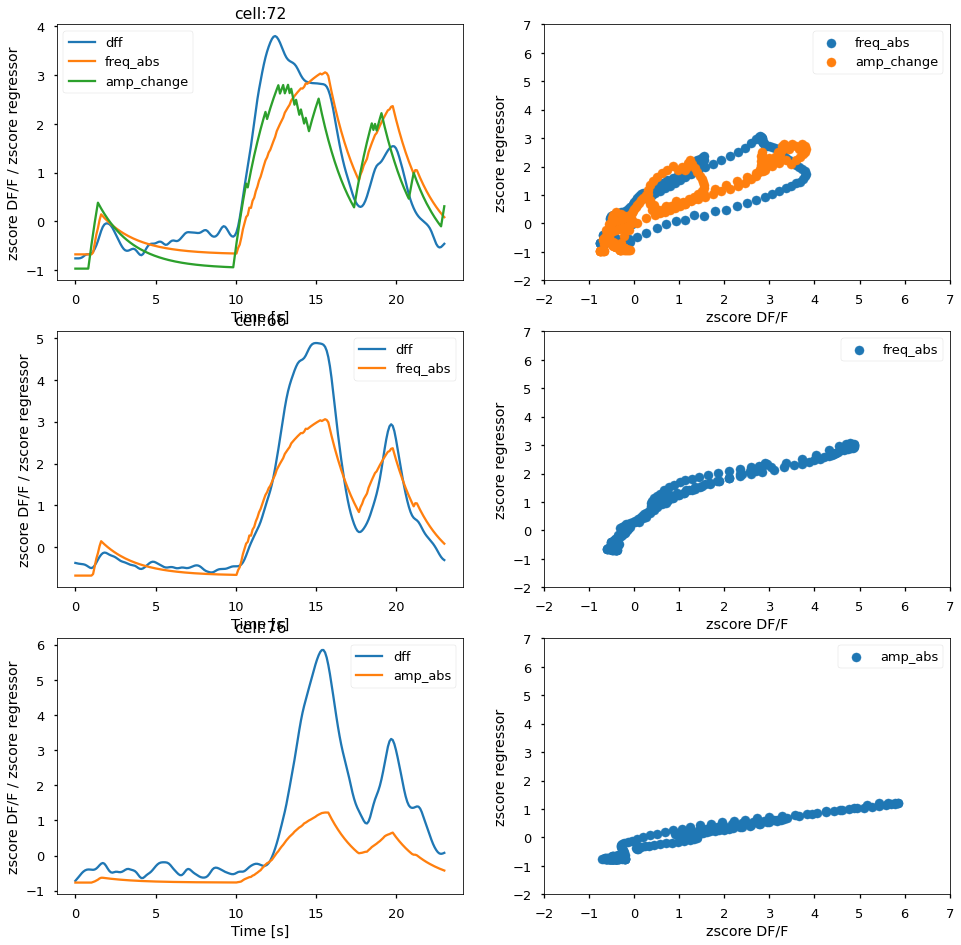

In [58]:
ex_neurons = {'72': ['freq_abs', 'amp_change'], '66': ['freq_abs'], '76': ['amp_abs']}
max_frame = 230

fig, ax = plt.subplots(3,2, figsize=(16,16))
for i,j in enumerate(ex_neurons):
    features = ex_neurons[j]
    ax[i,0].set_title('cell:'+j)
    ax[i,0].plot(time_indices_2p[:max_frame], zscore(dff[int(j),:])[:max_frame], label='dff')
    for k in features:
        ax[i,0].plot(time_indices_2p[:max_frame], zscore(regressors[k])[:max_frame], label=k)
        ax[i,1].scatter(zscore(dff[int(j),:])[:max_frame], zscore(regressors[k])[:max_frame], label=k)
    ax[i,0].legend()
    ax[i,1].legend()
    ax[i,0].set_xlabel('Time [s]')
    ax[i,0].set_ylabel('zscore DF/F / zscore regressor')
    ax[i,1].set_xlabel('zscore DF/F')
    ax[i,1].set_xlim(-2,7)
    ax[i,1].set_ylim(-2,7)
    ax[i,1].set_ylabel('zscore regressor')
fig.savefig(fig_path + 'example_cells_with_feature.svg')